In [1]:
# conda install seaborn

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns  # optional, if you like


In [3]:
# Read dataset
df = pd.read_csv("./model_testing/cleaned_concatenated_with_host_and_future_status.csv")

# Make a safe copy of the original data if needed
df_original = df.copy()

# If your CSV has an 'index' column that’s just repeated indices, drop it
# (If 'index' is not an irrelevant column, remove the drop line)
df.drop(columns=['index'], errors='ignore', inplace=True)
df

,Year,NOC,Total_Athletes,Total_Medal_Count,host_status,future_host_status
0,1896,Afghanistan,0,0,0,0
1,1896,Albania,0,0,0,0
2,1896,Algeria,0,0,0,0
3,1896,American Samoa,0,0,0,0
4,1896,Andorra,0,0,0,0
...,...,...,...,...,...,...
6685,2024,Vietnam,15,0,0,0
6686,2024,Virgin Islands,0,0,0,0
6687,2024,Yemen,4,0,0,0
6688,2024,Zambia,31,1,0,0


In [4]:
# 2.1: Winning Ratio
df['Winning_Ratio'] = df.apply(
    lambda row: row['Total_Medal_Count'] / row['Total_Athletes'] 
                if row['Total_Athletes'] > 0 else 0,
    axis=1
)

# 2.2: Keep a simple mapping of [NOC, Year, Total_Medal_Count] for merges/visuals
mapping_df = df[['NOC', 'Year', 'Total_Medal_Count']].copy()

# 2.3: Sort data by NOC, then by Year for lag-based features
df.sort_values(by=['NOC', 'Year'], inplace=True)
df.reset_index(drop=True, inplace=True)
mapping_df

,NOC,Year,Total_Medal_Count
0,Afghanistan,1896,0
1,Albania,1896,0
2,Algeria,1896,0
3,American Samoa,1896,0
4,Andorra,1896,0
...,...,...,...
6685,Vietnam,2024,0
6686,Virgin Islands,2024,0
6687,Yemen,2024,0
6688,Zambia,2024,1


In [5]:
# df = df.sort_values(by=['NOC', 'Year']).reset_index(drop=True)
# df

In [6]:
# Create lag features
lags = [1, 2, 3]
for lag in lags:
    df[f'Medals_lag_{lag}'] = df.groupby('NOC')['Total_Medal_Count'].shift(lag)

# Rolling mean of the last 3 observations
df['Rolling_Mean_3'] = df.groupby('NOC')['Total_Medal_Count'].transform(lambda x: x.rolling(3).mean())

# Drop any rows that now contain NaN (due to shift/rolling)
df.dropna(inplace=True)


In [7]:
df

,Year,NOC,Total_Athletes,Total_Medal_Count,host_status,future_host_status,Winning_Ratio,Medals_lag_1,Medals_lag_2,Medals_lag_3,Rolling_Mean_3
3,1908,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
4,1912,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
5,1920,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
6,1924,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
7,1928,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6685,2008,Zimbabwe,13,4,0,0,0.307692,3.0,0.0,0.0,2.333333
6686,2012,Zimbabwe,7,0,0,0,0.000000,4.0,3.0,0.0,2.333333
6687,2016,Zimbabwe,30,0,0,0,0.000000,0.0,4.0,3.0,1.333333
6688,2020,Zimbabwe,5,0,0,0,0.000000,0.0,0.0,4.0,0.000000


In [8]:
df.dropna(inplace=True)  # Drop rows with any NaN values
df

,Year,NOC,Total_Athletes,Total_Medal_Count,host_status,future_host_status,Winning_Ratio,Medals_lag_1,Medals_lag_2,Medals_lag_3,Rolling_Mean_3
3,1908,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
4,1912,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
5,1920,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
6,1924,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
7,1928,Afghanistan,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6685,2008,Zimbabwe,13,4,0,0,0.307692,3.0,0.0,0.0,2.333333
6686,2012,Zimbabwe,7,0,0,0,0.000000,4.0,3.0,0.0,2.333333
6687,2016,Zimbabwe,30,0,0,0,0.000000,0.0,4.0,3.0,1.333333
6688,2020,Zimbabwe,5,0,0,0,0.000000,0.0,0.0,4.0,0.000000


In [9]:
# X = df.drop(columns=['Total_Medal_Count','Year'])  # Features
# y = df['Total_Medal_Count']  # T
# X

In [10]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# encoded_noc = encoder.fit_transform(X[['NOC']])
# encoded_noc_df = pd.DataFrame(encoded_noc, columns=encoder.get_feature_names_out(['NOC']))
# X = pd.concat([X.drop(columns=['NOC']), encoded_noc_df], axis=1)

In [11]:
# df = pd.get_dummies(df, columns=['NOC'], drop_first=True)
# df

In [12]:
df.columns

Index(['Year', 'NOC', 'Total_Athletes', 'Total_Medal_Count', 'host_status',
       'future_host_status', 'Winning_Ratio', 'Medals_lag_1', 'Medals_lag_2',
       'Medals_lag_3', 'Rolling_Mean_3'],
      dtype='object')

In [13]:
split_year = 1996
df_train = df[df['Year'] <= split_year].copy()
df_test  = df[df['Year'] > split_year].copy()

mapping_df_train = mapping_df[mapping_df['Year'] <= split_year].copy()
mapping_df_test  = mapping_df[mapping_df['Year'] > split_year].copy()


In [14]:
# mapping_df_train = mapping_df[mapping_df['Year'] <= split_year]
# mapping_df_test = mapping_df[mapping_df['Year'] > split_year]

In [15]:
# Choose relevant features for modeling
features = [
    'Total_Athletes',
    'host_status',
    'Rolling_Mean_3',
    'Winning_Ratio',
    'Medals_lag_2'
]

X_train = df_train[features]
y_train = df_train['Total_Medal_Count']

X_test = df_test[features]
y_test = df_test['Total_Medal_Count']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4460, 5)
y_train shape: (4460,)
X_test shape:  (1561, 5)
y_test shape: (1561,)


In [16]:

# from sklearn.model_selection import GridSearchCV

# # Define a parameter grid to search over
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     # You can add more parameters if needed
# }

# # Initialize a base model
# rf = RandomForestRegressor(random_state=42)

# # Set up the GridSearch
# grid_search = GridSearchCV(
#     estimator=rf, 
#     param_grid=param_grid, 
#     scoring='neg_mean_squared_error',  # or 'neg_mean_absolute_error', 'r2', etc.
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # use all available CPU cores
#     verbose=1   # prints out the progress
# )

# # Fit on training data
# grid_search.fit(X_train, y_train)

# # The best hyperparameters found
# print("Best Parameters:", grid_search.best_params_)

# # The best estimator (model) using those hyperparameters
# best_model = grid_search.best_estimator_

# # Evaluate on test set
# y_pred_test = best_model.predict(X_test)

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# mse_test = mean_squared_error(y_test, y_pred_test)
# mae_test = mean_absolute_error(y_test, y_pred_test)
# r2_test  = r2_score(y_test, y_pred_test)

# print("MSE (Test):", mse_test)
# print("MAE (Test):", mae_test)
# print("R2  (Test):", r2_test)


In [17]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

MAE: 0.5507756211157413
MSE: 6.879103575775652
R²: 0.9530648703226011


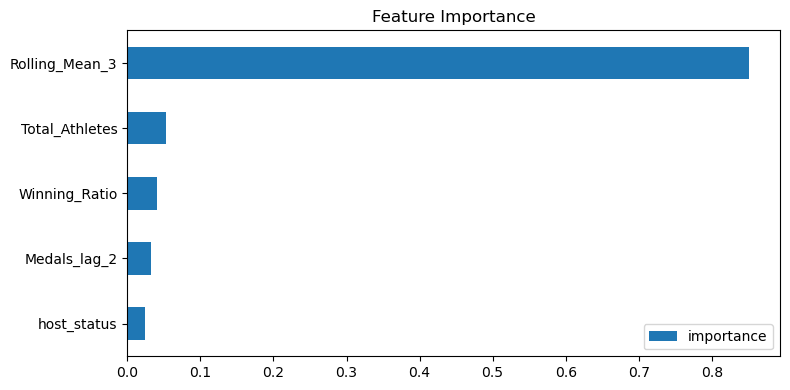

In [18]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate on test set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

# Feature Importances
fi = pd.DataFrame(
    data=model.feature_importances_,
    index=model.feature_names_in_,
    columns=["importance"]
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(8,4))
plt.tight_layout()
plt.show()


In [19]:
# Create a Series for predictions with index aligned to y_test
predictions_series = pd.Series(y_pred, index=y_test.index, name='Predicted_Total_Medal_Count')

# Attach to df_test
df_test['Predicted_Total_Medal_Count'] = predictions_series

# If you want a separate DataFrame with [NOC, Year, Actual, Predicted]:
results_df = df_test[['NOC', 'Year', 'Total_Medal_Count']].copy()
results_df['Predicted_Total_Medal_Count'] = df_test['Predicted_Total_Medal_Count']

# Or you can merge with mapping_df_test to ensure the same columns:
merged_results_df = mapping_df_test.merge(
    predictions_series, 
    left_index=True, 
    right_index=True, 
    how='left'
)
merged_results_df.rename(columns={'prediction': 'Predicted_Total_Medal_Count'}, inplace=True)


In [20]:
results_df

,NOC,Year,Total_Medal_Count,Predicted_Total_Medal_Count
23,Afghanistan,2000,0,0.000000
24,Afghanistan,2004,0,0.000000
25,Afghanistan,2008,1,1.001000
26,Afghanistan,2012,1,1.406544
27,Afghanistan,2016,0,0.002500
...,...,...,...,...
6685,Zimbabwe,2008,4,4.646815
6686,Zimbabwe,2012,0,0.000000
6687,Zimbabwe,2016,0,0.000000
6688,Zimbabwe,2020,0,0.000000


In [21]:
# prediction_df = mapping_df_test.merge(predictions_series, how='left', left_index=True, right_index=True)


In [22]:
# prediction_df

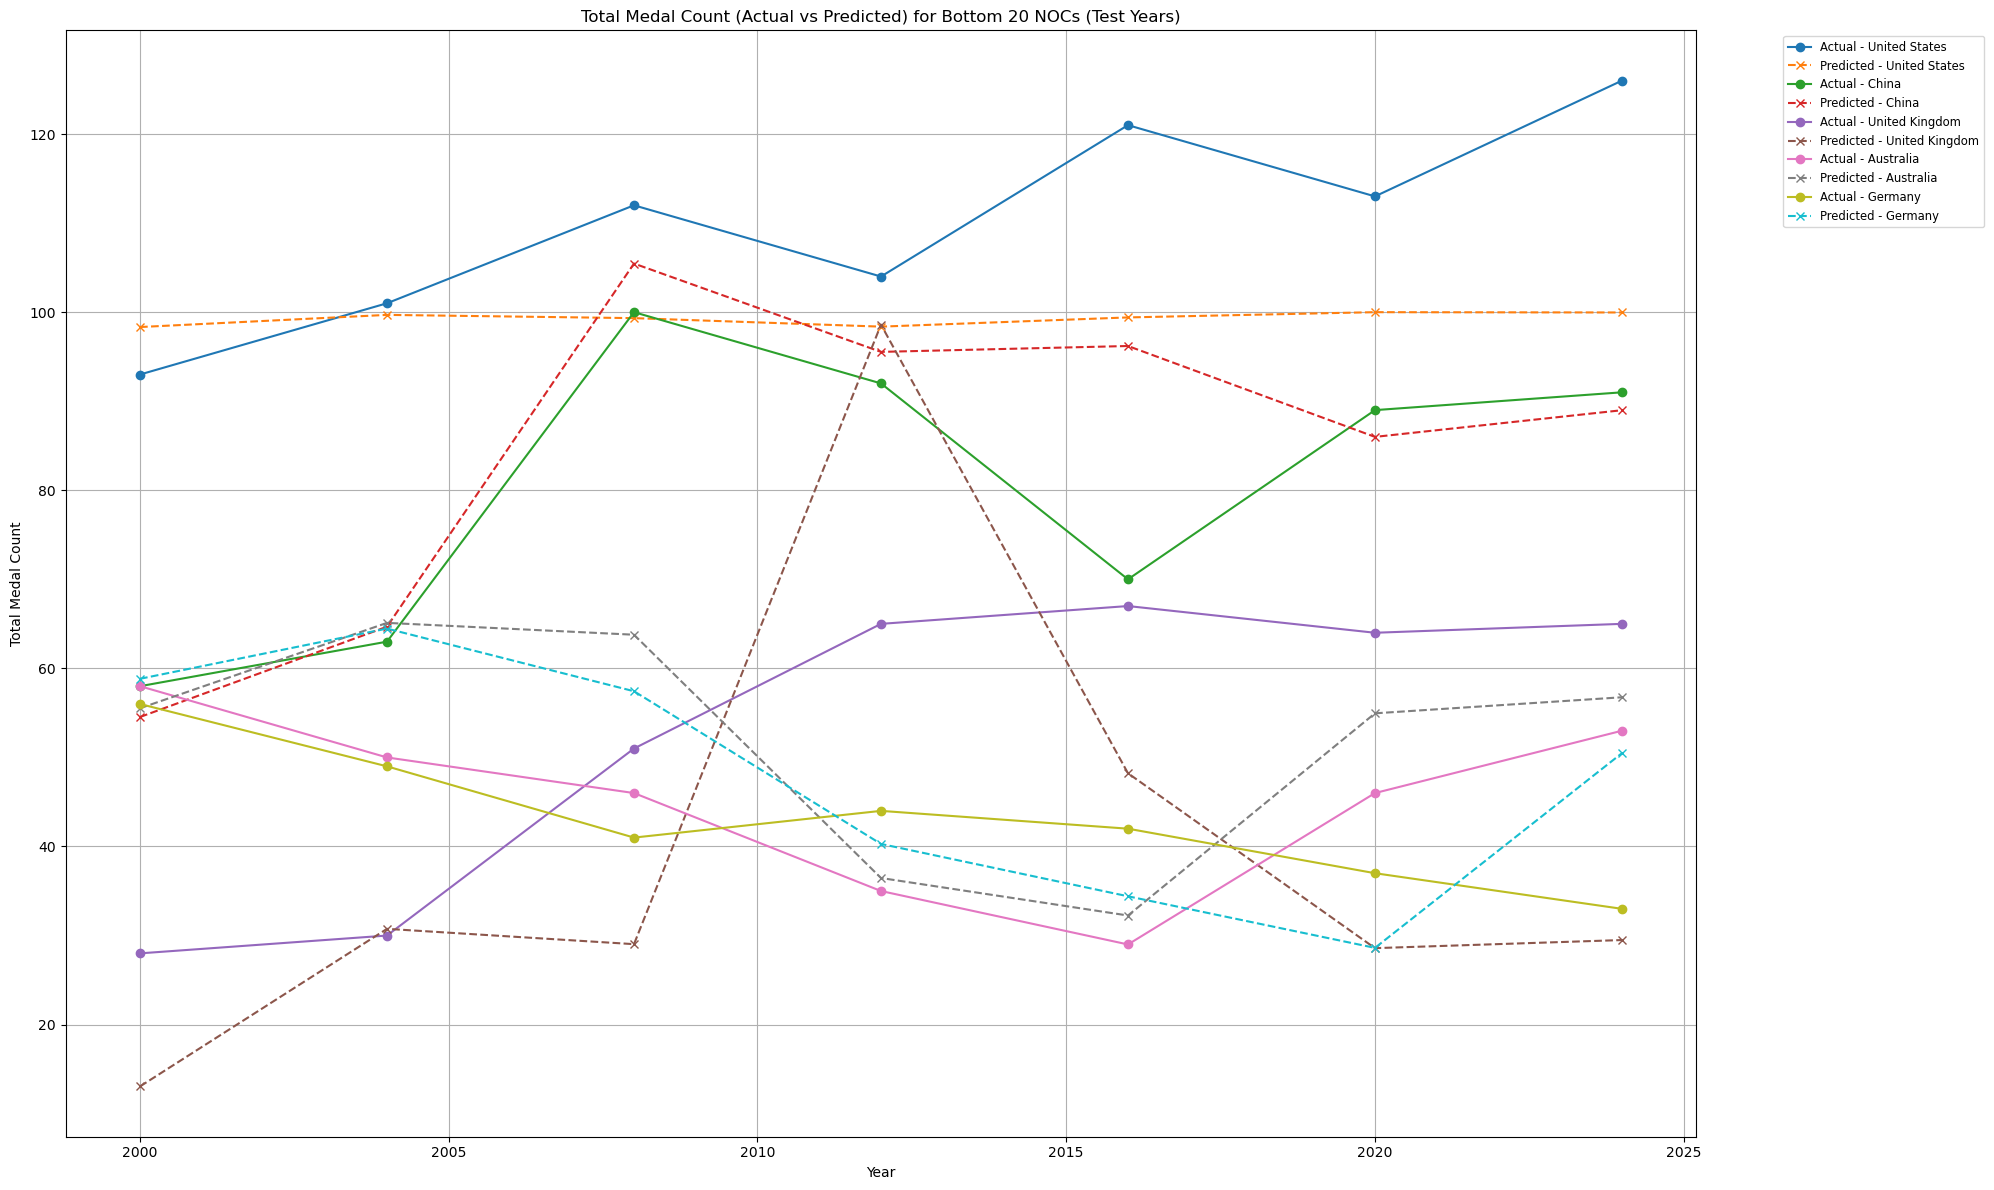

In [29]:
# Group by NOC in the test set, sum of actual medals
noc_medal_counts = df_test.groupby('NOC')['Total_Medal_Count'].sum().reset_index()

# Sort in ascending order and pick bottom 20
bottom_20_nocs = noc_medal_counts.sort_values(by='Total_Medal_Count', ascending=False).head(5)['NOC'].tolist()

# Filter test data for these bottom 20 NOCs
filtered_df = df_test[df_test['NOC'].isin(bottom_20_nocs)]

plt.figure(figsize=(20, 12))

for noc in bottom_20_nocs:
    # Data for this NOC
    noc_data = filtered_df[filtered_df['NOC'] == noc]
    
    # Plot Actual
    plt.plot(
        noc_data['Year'], 
        noc_data['Total_Medal_Count'], 
        marker='o', 
        label=f'Actual - {noc}'
    )
    
    # Plot Predicted
    plt.plot(
        noc_data['Year'], 
        noc_data['Predicted_Total_Medal_Count'], 
        marker='x', 
        linestyle='--', 
        label=f'Predicted - {noc}'
    )

plt.xlabel('Year')
plt.ylabel('Total Medal Count')
plt.title('Total Medal Count (Actual vs Predicted) for Bottom 20 NOCs (Test Years)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
df_test['Predicted_Total_Medal_Count'] = y_pred
df_test[['Year', 'NOC', 'Total_Medal_Count', 'Predicted_Total_Medal_Count']].head()


,Year,NOC,Total_Medal_Count,Predicted_Total_Medal_Count
23,2000,Afghanistan,0,0.000000
24,2004,Afghanistan,0,0.000000
25,2008,Afghanistan,1,1.001000
26,2012,Afghanistan,1,1.406544
27,2016,Afghanistan,0,0.002500


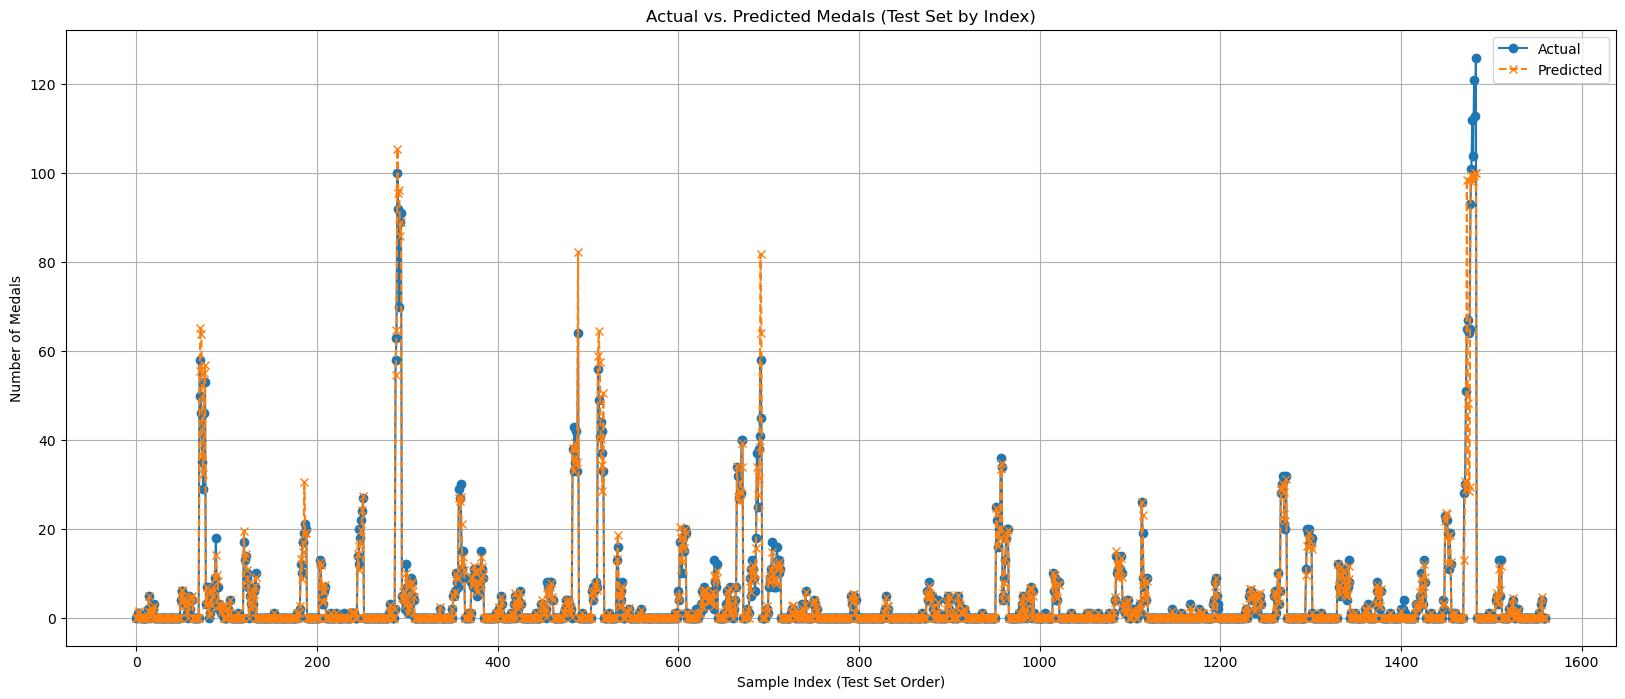

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Medals (Test Set by Index)')
plt.xlabel('Sample Index (Test Set Order)')
plt.ylabel('Number of Medals')
plt.legend()
plt.grid(True)
plt.show()


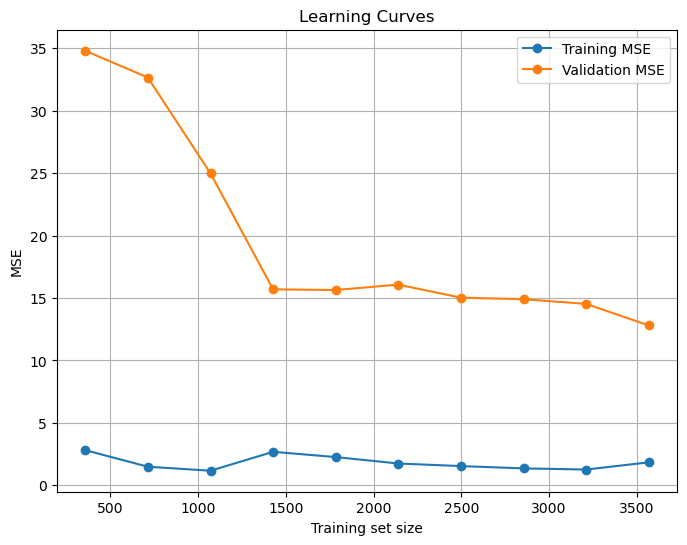

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training MSE')
plt.plot(train_sizes, validation_scores_mean, 'o-', label='Validation MSE')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [27]:
# import matplotlib.pyplot as plt

# # ... (Your data loading, preprocessing, model training, and merging code as before)

# # Ensure y_test and y_pred are NumPy arrays (assuming they are DataFrames)
# # y_test = y_test.values.ravel()
# # y_pred = y_pred.values.ravel()

# # Get the top 20 NOCs based on total medal count in the original data
# top_20_nocs = df_original.groupby('NOC')['Total_Medal_Count'].sum().nlargest(20).index.tolist()

# # Filter data for top 20 NOCs and years after 1996 (assuming 'Year' is a numeric column)
# prediction_df_top20_after_1996 = prediction_df[(prediction_df['NOC'].isin(top_20_nocs)) & (prediction_df['Year'] > 1996)]
# y_test_top20_after_1996 = y_test[prediction_df_top20_after_1996.index]

# # Create the plot
# plt.figure(figsize=(20, 14))
# plt.plot(y_test_top20_after_1996, label='Actual')
# plt.plot(y_pred[merged_df_top20_after_1996.index], label='Predicted', linestyle='--')  # Select predictions for filtered indices
# plt.title('Actual vs Predicted Medals (Top 20 NOCs, After 1996)')
# plt.xlabel('Sample Index')
# plt.ylabel('Number of Medals')
# plt.legend()
# plt.show()


In [28]:

# Merge with the mapping DataFrame to get NOC and Year
results_df = pd.merge(mapping_df_test, prediction_df['prediction'], left_index=True, right_index=True, how='inner')


# Visualization: Actual vs. Predicted for the United States (Test Years Only)
noc_to_visualize = 'United States'  # Or 'USA' if that's how it's in your data
noc_data = results_df[results_df['NOC'] == noc_to_visualize]

noc_data

NameError: name 'prediction_df' is not defined

In [ ]:
noc_to_visualize = 'United Kingdom'

noc_data = df_test[df_test['NOC'] == noc_to_visualize].copy()
if noc_data.empty:
    print(f"No data found for {noc_to_visualize} in the test set.")
else:
    plt.figure(figsize=(10, 6))
    plt.plot(noc_data['Year'], noc_data['Total_Medal_Count'], marker='o', label='Actual Medals')
    plt.plot(noc_data['Year'], noc_data['Predicted_Total_Medal_Count'], marker='x', linestyle='--', label='Predicted Medals')
    plt.xlabel('Year')
    plt.ylabel('Total Medal Count')
    plt.title(f'Actual vs. Predicted Medals for {noc_to_visualize} (Test Years Only)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
df2 = df_original
ax=df2[['Total_Medal_Count']].plot(figsize=(20,15))
merged_df['prediction'].plot(ax=ax,style='.')
ax.set_title('Raw data and Predictions')

In [ ]:
# Get the top 20 NOCs based on total medal count in the original data
top_20_nocs = df_original.groupby('NOC')['Total_Medal_Count'].sum().nlargest(20).index.tolist()

# Filter merged_df and df_original for the top 20 NOCs
merged_df_top20 = merged_df[merged_df['NOC'].isin(top_20_nocs)]
df_original_top20 = df_original[df_original['NOC'].isin(top_20_nocs)]

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plot actual medal counts for top 20 NOCs
for noc in top_20_nocs:
    noc_data_original = df_original_top20[df_original_top20['NOC'] == noc].set_index('Year')
    noc_data_original['Total_Medal_Count'].plot(ax=ax, label=f'{noc} (Actual)')

# Plot predictions for top 20 NOCs
for noc in top_20_nocs:
    noc_data_predictions = merged_df_top20[merged_df_top20['NOC'] == noc].set_index('Year')
    noc_data_predictions['prediction'].plot(ax=ax, style='.', label=f'{noc} (Predicted)')

ax.set_title('Raw Data and Predictions for Top 20 NOCs')
ax.set_xlabel('Year')
ax.set_ylabel('Total Medal Count')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed
plt.tight_layout()
plt.show()


In [ ]:
# Get the top 20 NOCs based on total medal count in the original data
top_20_nocs = df_original.groupby('NOC')['Total_Medal_Count'].sum().nlargest(5).index.tolist()

# Filter merged_df for the top 20 NOCs
merged_df_top20 = merged_df[merged_df['NOC'].isin(top_20_nocs)]

# Get the predicted years (years in the test set)
predicted_years = merged_df_top20['Year'].unique()

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plot actual medal counts for top 20 NOCs for predicted years only
for noc in top_20_nocs:
    noc_data_original = df_original[(df_original['NOC'] == noc) & (df_original['Year'].isin(predicted_years))].set_index('Year')
    if not noc_data_original.empty:  # Check if there's data for this NOC in predicted years
        noc_data_original['Total_Medal_Count'].plot(ax=ax, label=f'{noc} (Actual)', marker='o')

# Plot predictions for top 20 NOCs (using dotted lines)
for noc in top_20_nocs:
    noc_data_predictions = merged_df_top20[merged_df_top20['NOC'] == noc].set_index('Year')
    noc_data_predictions['prediction'].plot(ax=ax, style=':', label=f'{noc} (Predicted)', marker='x') #Changed style to :

ax.set_title('Raw Data and Predictions for Top 20 NOCs (Predicted Years Only)')
ax.set_xlabel('Year')
ax.set_ylabel('Total Medal Count')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Total Medal Count')
plt.ylabel('Predicted Total Medal Count')
plt.title('Actual vs. Predicted Total Medal Count')
plt.grid(True)
plt.show()

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='k', linestyle='--')  # Horizontal line at y = 0
plt.xlabel('Predicted Total Medal Count')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, validation_scores = learning_curve(
#     model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
# )

# train_scores_mean = -train_scores.mean(axis=1)
# validation_scores_mean = -validation_scores.mean(axis=1)

# plt.figure(figsize=(8, 6))
# plt.plot(train_sizes, train_scores_mean, 'o-', label='Training error')
# plt.plot(train_sizes, validation_scores_mean, 'o-', label='Validation error')
# plt.xlabel('Training set size')
# plt.ylabel('MSE')
# plt.title('Learning Curves')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()

In [ ]:
# Create predictions DataFrame with indices for visualization mapping
predictions_df = pd.DataFrame({'Predicted_Total_Medals': y_pred}, index=y_test.index)

# Merge with the original DataFrame for visualization (correct mapping)
results_df = pd.merge(df_original[['NOC', 'Year', 'Total_Medal_Count']], predictions_df, left_index=True, right_index=True, how='inner')

# Save to CSV
file_path = './predicted_total_medals.csv'
results_df.to_csv(file_path, index=False)
print(f"Predicted total medal counts saved to {file_path}")
